In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import ot
import sklearn
import time
from sklearn import datasets
import pylab
import math
import proplot as plot
plot.rc['figure.facecolor'] = "white"
from scipy.stats import random_correlation

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

torch.manual_seed(0)

Used device: cpu


In [3]:
import sys
sys.path.append('../code/')

In [4]:
from SWGG import SWGG_CP,SWGG_smooth,get_SWGG_smooth
from utils import random_slice
from Simulated_Annealing import SWGG_annealing

# Convergence in dimension 2

## sample points from 2 different gaussian distributions

In [5]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 2
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)
cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)

## compute SWGG for varying number of projections + optimization

In [6]:
# Monte Carlo

dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_2 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_2[seed, i]= torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_2 = np.mean(res_minSWGG_2, axis=0)
res_minSWGG_std_2 = np.std(res_minSWGG_2, axis=0)

In [7]:
# Simulated annealing

theta=random_slice(1,dim).T
theta_0=theta[:,0].double()

n_iter=500
_,best_theta_annealing2,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)


In [8]:
#Optim

lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_2=t/torch.norm(t)
best_theta_2 = SWGG_CP(X, Y, torch.reshape(t_min_2, (-1,1)))[0]

100%|█████████████████████████| 200/200 [00:00<00:00, 379.11it/s, loss = 34.164]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


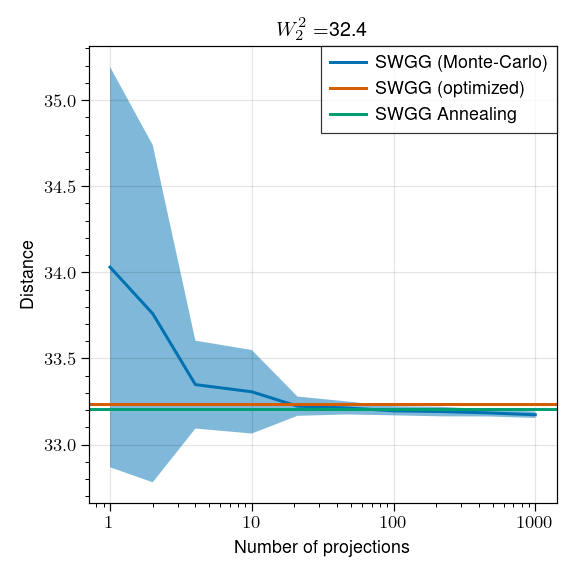

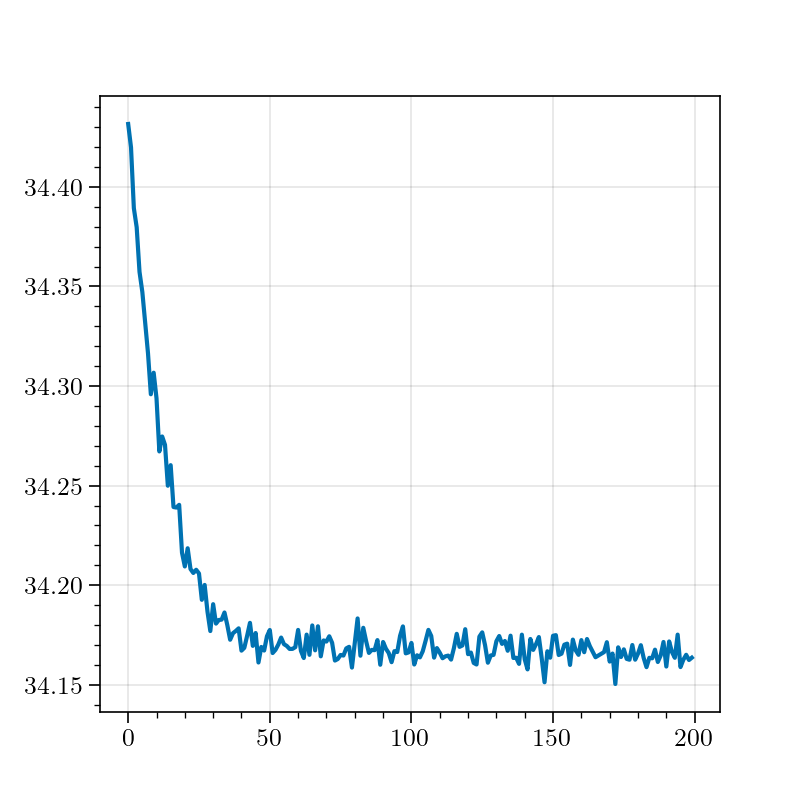

In [18]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})


pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_2, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_2 - 2 * res_minSWGG_std_2, res_minSWGG_mean_2 + 2 * res_minSWGG_std_2, alpha=0.5)
pl.axhline(y = best_theta_2, color = 'C1', label = 'SWGG (optimized)')
pl.axhline(y = best_theta_annealing2, color = 'C2', label = 'SWGG Annealing')

pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd2 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd2,2)))
pl.tight_layout()
#pl.savefig("montecarlo_vs_optim_dim2",bbox_inches='tight')


pl.show()
pl.plot(loss_swgg_l)
pl.show()

# Convergence in dimension 20

## sample points from 2 different gaussian distributions

In [19]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 20
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)

#cov_s = random_correlation.rvs(np.ones(dim), random_state=2023)
#cov_t = random_correlation.rvs(np.random.randint(4,5,dim)*dim/np.sum(np.random.randint(4,5,dim)), random_state=2023)

cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)


/tmp/ipykernel_12566/1794733436.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)


In [20]:
dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_20 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_20[seed, i]= torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_20 = np.mean(res_minSWGG_20, axis=0)
res_minSWGG_std_20 = np.std(res_minSWGG_20, axis=0)

In [21]:
# Simulated annealing

theta=random_slice(1,dim).T
theta_0=theta[:,0].double()

n_iter=500
_,best_theta_annealing20,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)


In [22]:
lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_20=t/torch.norm(t)
best_theta_20 = SWGG_CP(X, Y, torch.reshape(t_min_20, (-1,1)))[0]

100%|████████████████████████| 200/200 [00:00<00:00, 330.85it/s, loss = 423.542]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


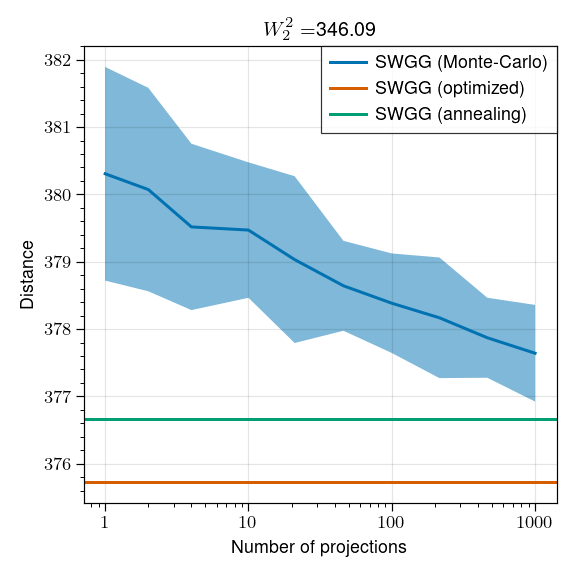

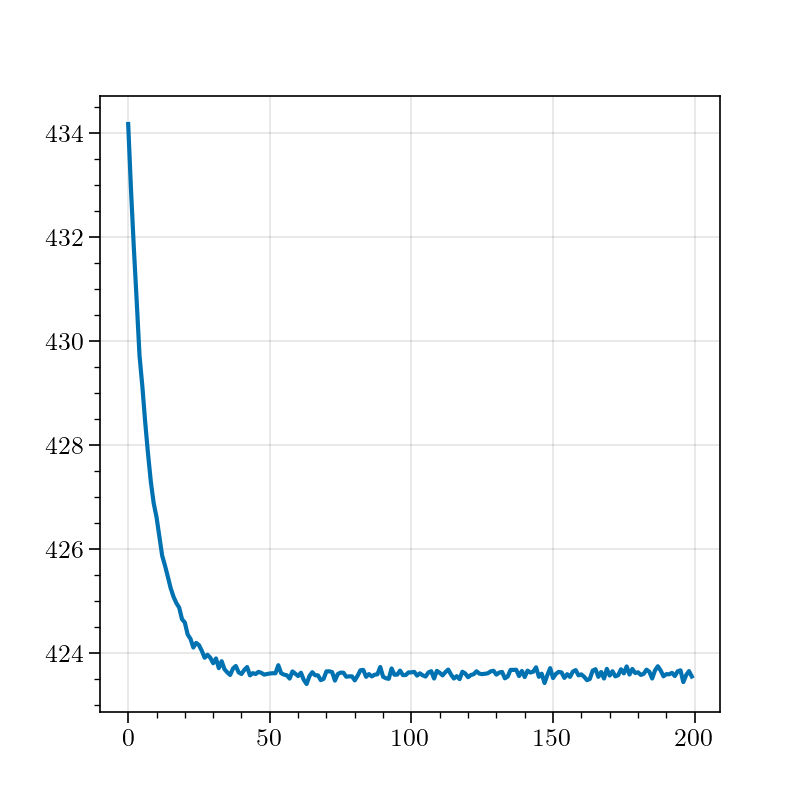

In [23]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_20, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_20 - 2 * res_minSWGG_std_20, res_minSWGG_mean_20 + 2 * res_minSWGG_std_20, alpha=0.5)
pl.axhline(y = best_theta_20, color = 'C1', label = 'SWGG (optimized)')
pl.axhline(y = best_theta_annealing20, color = 'C2', label = 'SWGG (annealing)')
pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd20 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd20,2)))
pl.tight_layout()
#pl.savefig("montecarlo_vs_optim_dim20",bbox_inches='tight')

pl.show()
pl.plot(loss_swgg_l)
pl.show()

# Convergence in dimension 200

In [24]:
np.random.seed(seed=2023)
n_samples = 1000
dim = 200
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)

#cov_s = random_correlation.rvs(np.ones(dim), random_state=2023)
#cov_t = random_correlation.rvs(np.random.randint(4,5,dim)*dim/np.sum(np.random.randint(4,5,dim)), random_state=2023)

cov_t = np.ones((dim,dim))*-.8
for i in range(dim):
    cov_t[i,i]=1

xs = np.random.multivariate_normal(mu_s, cov_s, n_samples)
xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)
X = torch.from_numpy(xs).to(device)
Y = torch.from_numpy(xt).to(device)


/tmp/ipykernel_12566/2673229714.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  xt = np.random.multivariate_normal(mu_t, cov_t, n_samples)


In [25]:
dim=xs.shape[1]

n_seed = 20
n_projections_arr = np.logspace(0, 3, 10, dtype=int)
res = np.empty((n_seed, 10))
res_minSWGG_200 = np.empty((n_seed, 10))

np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_projections in enumerate(n_projections_arr):
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        res_minSWGG_200[seed, i]= torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        
res_minSWGG_mean_200 = np.mean(res_minSWGG_200, axis=0)
res_minSWGG_std_200 = np.std(res_minSWGG_200, axis=0)

In [26]:
# Simulated annealing

theta=random_slice(1,dim).T
theta_0=theta[:,0].double()

n_iter=500
_,best_theta_annealing200,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)


In [27]:
lr=5e-2
num_iter=200
s = 10
std=1
t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
t.requires_grad=False
t_min_200=t/torch.norm(t)
best_theta_200 = SWGG_CP(X, Y, torch.reshape(t_min_200, (-1,1)))[0]

100%|████████████████████████| 200/200 [00:03<00:00, 61.14it/s, loss = 4431.654]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


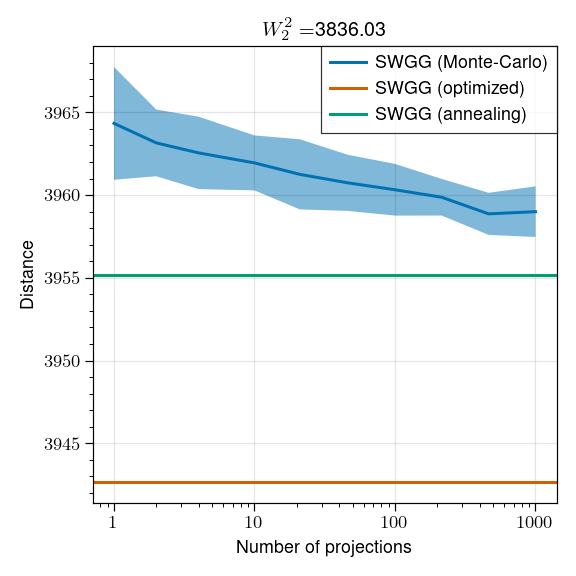

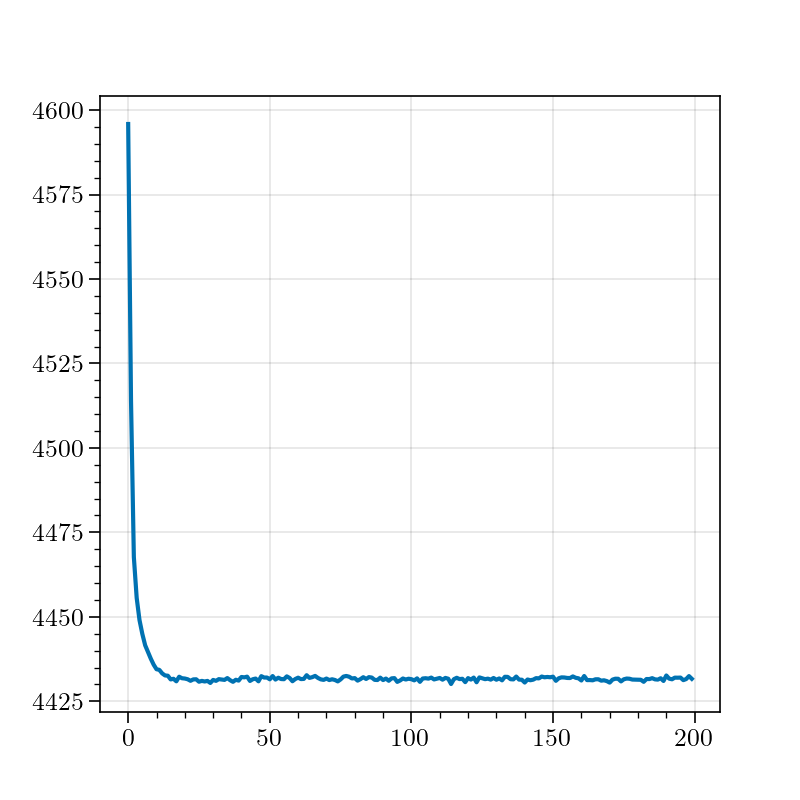

In [28]:
pl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

pl.figure(2)
pl.plot(n_projections_arr, res_minSWGG_mean_200, label="SWGG (Monte-Carlo)")
pl.fill_between(n_projections_arr, res_minSWGG_mean_200 - 2 * res_minSWGG_std_200, res_minSWGG_mean_200 + 2 * res_minSWGG_std_200, alpha=0.5)
pl.axhline(y = best_theta_200, color = 'C1', label = 'SWGG (optimized)')
pl.axhline(y = best_theta_annealing200, color = 'C2', label = 'SWGG (annealing)')

pl.legend()
pl.xscale('log')

pl.xlabel("Number of projections")
pl.ylabel("Distance")
emd_200 = ot.emd2([], [], ot.dist(X.detach().numpy(), Y.detach().numpy()))
pl.title('$W_2^2 = $'+str(np.round(emd_200,2)))
pl.tight_layout()
#pl.savefig("montecarlo_vs_optim_dim200.pdf",bbox_inches='tight')


pl.show()
pl.plot(loss_swgg_l)
pl.show()

# final figure

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to

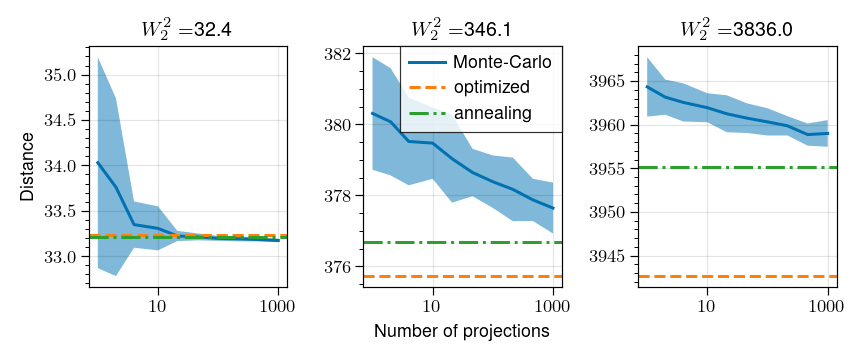

In [29]:
pl.rcParams["figure.figsize"] = (6,2.5)
pl.subplot(131)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean_2)
pl.fill_between(n_projections_arr, res_minSWGG_mean_2 - 2 * res_minSWGG_std_2, res_minSWGG_mean_2 + 2 * res_minSWGG_std_2, alpha=0.5)
pl.axhline(y = best_theta_2,color='tab:orange', ls='--' )
pl.axhline(y = best_theta_annealing2,color='tab:green', ls='-.' )

pl.ylabel("Distance")
pl.title('$W_2^2 = $'+str(np.round(emd2,1)))
pl.tight_layout()

pl.subplot(132)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean_20, label="Monte-Carlo")
pl.fill_between(n_projections_arr, res_minSWGG_mean_20 - 2 * res_minSWGG_std_20, res_minSWGG_mean_20 + 2 * res_minSWGG_std_20, alpha=0.5)
pl.axhline(y = best_theta_20,color='tab:orange', ls='--', label="optimized" )
pl.axhline(y = best_theta_annealing20,color='tab:green', ls='-.', label="annealing" )
pl.xlabel("Number of projections")
pl.title('$W_2^2 = $'+str(np.round(emd20,1)))
pl.legend()
pl.subplot(133)
pl.xscale('log')
pl.plot(n_projections_arr, res_minSWGG_mean_200)
pl.fill_between(n_projections_arr, res_minSWGG_mean_200 - 2 * res_minSWGG_std_200, res_minSWGG_mean_200 + 2 * res_minSWGG_std_200, alpha=0.5)
pl.axhline(y = best_theta_200,color='tab:orange', ls='--', label="optimized" )
pl.axhline(y = best_theta_annealing200,color='tab:green', ls='-.', label="annealing" )
pl.title('$W_2^2 = $'+str(np.round(emd_200,1)))
pl.tight_layout()
pl.savefig("montecarlo_optim_annealing.pdf",bbox_inches='tight')

# Timing

In [10]:
from sklearn.datasets import make_spd_matrix

In [11]:
#dim 2
np.random.seed(seed=2023)
n_samples = 500
dim = 2
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)
cov_t = make_spd_matrix(dim, random_state=3)

n_seed = 1
n_samples = np.logspace(1, 4, 10, dtype=int)
timings = []
timing_annealing = []
timings_optim = []
n_projections = 500

lr=5e-2
num_iter=100
s = 10
std=1
        
np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_s in enumerate(n_samples):
        #sample points
        xs = np.random.multivariate_normal(mu_s, cov_s, n_s)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_s)
        X = torch.from_numpy(xs).to(device)
        Y = torch.from_numpy(xt).to(device)
        
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        start = time.time()
        torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        timings.append(time.time()-start)

        theta=random_slice(1,dim).T
        theta_0=theta[:,0].double()
        n_iter=500
        start = time.time()
        _,best_theta_annealing20,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)
        timing_annealing.append(time.time()-start)
        
        start = time.time()
        t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
        t.requires_grad=False
        t_min_20=t/torch.norm(t)
        timings_optim.append(time.time()-start)
        
#20       
np.random.seed(seed=2023)
n_samples = 500
dim = 20
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)
cov_t = make_spd_matrix(dim, random_state=3)
n_seed = 1
n_samples = np.logspace(1, 4, 10, dtype=int)
timings_20 = []
timing_annealing_20 =[]
timings_optim_20 = []
n_projections = 500


np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_s in enumerate(n_samples):
        #sample points
        xs = np.random.multivariate_normal(mu_s, cov_s, n_s)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_s)
        X = torch.from_numpy(xs).to(device)
        Y = torch.from_numpy(xt).to(device)
        
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        start = time.time()
        torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        timings_20.append(time.time()-start)
        
        theta=random_slice(1,dim).T
        theta_0=theta[:,0].double()
        n_iter=500
        start = time.time()
        _,best_theta_annealing20,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)
        timing_annealing_20.append(time.time()-start)
        
        start = time.time()
        t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
        t.requires_grad=False
        t_min=t/torch.norm(t)
        timings_optim_20.append(time.time()-start)

#200       
np.random.seed(seed=2023)
n_samples = 500
dim = 200
mu_s = np.random.randint(0,1,dim)
cov_s = np.diag(np.ones(dim))
mu_t = np.random.randint(4,5,dim)
cov_t = make_spd_matrix(dim, random_state=3)
n_seed = 1
n_samples = np.logspace(1, 4, 10, dtype=int)
timings_200 = []
timing_annealing_200 = []
timings_optim_200 = []
n_projections = 500


np.random.seed(seed=2023)
for seed in range(n_seed):
    for i, n_s in enumerate(n_samples):
        print(n_samples)
        #sample points
        xs = np.random.multivariate_normal(mu_s, cov_s, n_s)
        xt = np.random.multivariate_normal(mu_t, cov_t, n_s)
        X = torch.from_numpy(xs).to(device)
        Y = torch.from_numpy(xt).to(device)
        
        #Warm start
        projections = np.random.randn(dim, 1)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])     
        
        projections = np.random.randn(dim, n_projections)
        projections = projections / np.sqrt(np.sum(projections**2, 0, keepdims=True))
        start = time.time()
        torch.min(SWGG_CP(X, Y, torch.from_numpy(projections).to(device))[0])
        timings_200.append(time.time()-start)
        
        theta=random_slice(1,dim).T
        theta_0=theta[:,0].double()
        n_iter=500
        start = time.time()
        _,best_theta_annealing200,_=SWGG_annealing(X,Y,theta_0,n_iter,eps=1e-1)
        timing_annealing_200.append(time.time()-start)
        
        start = time.time()
        t,loss_swgg_l, th = get_SWGG_smooth(X,Y,lr=lr,num_iter=num_iter,s=s,std=std)
        t.requires_grad=False
        t_min=t/torch.norm(t)
        timings_optim_200.append(time.time()-start)


100%|█████████████████████████| 100/100 [00:03<00:00, 32.62it/s, loss = 388.046]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 863.80it/s, loss = 3648.876]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 782.74it/s, loss = 3904.964]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 763.79it/s, loss = 3909.760]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 567.54it/s, loss = 3948.049]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 300.27it/s, loss = 3904.508]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|███████████████████████| 100/100 [00:00<00:00, 130.62it/s, loss = 3919.708]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|████████████████████████| 100/100 [00:01<00:00, 63.40it/s, loss = 3943.878]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|████████████████████████| 100/100 [00:03<00:00, 26.73it/s, loss = 3944.759]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|████████████████████████| 100/100 [00:07<00:00, 13.28it/s, loss = 3940.711]


[   10    21    46   100   215   464  1000  2154  4641 10000]


100%|████████████████████████| 100/100 [00:16<00:00,  6.18it/s, loss = 3941.488]


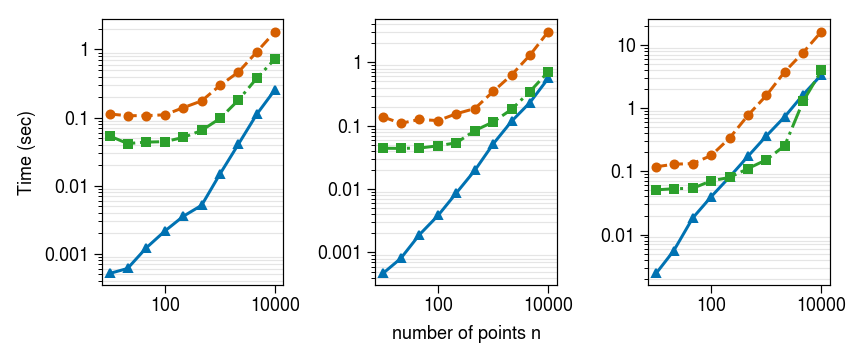

In [12]:
pl.rcParams["figure.figsize"] = (6,2.5)
pl.subplot(131)
pl.plot(n_samples, timings, linestyle = '-', marker = '^', markersize=4)
pl.plot(n_samples, timings_optim, linestyle = '--', marker = 'o', markersize=4)
pl.plot(n_samples, timing_annealing, linestyle = '-.',color='tab:green', marker = 's', markersize=4)
pl.xscale('log')
pl.yscale('log')
pl.ylabel('Time (sec)')
#pl.ylim(1e-3,1e2)
pl.grid(which='both')
pl.tight_layout()

pl.subplot(132)
pl.plot(n_samples, timings_20, linestyle = '-', marker = '^', markersize=4, label="Monte Carlo")
pl.plot(n_samples, timings_optim_20, linestyle = '--', marker = 'o', markersize=4, label = "Optim")
pl.plot(n_samples, timing_annealing_20, linestyle = '-.',color='tab:green', marker = 's', markersize=4,label="Annealing")
pl.xlabel('number of points $n$')
pl.xscale('log')
pl.yscale('log')
#pl.ylim(1e-3,1e2)
pl.grid(which='both')

pl.subplot(133)
pl.plot(n_samples, timings_200, linestyle = '-', marker = '^', markersize=4)
pl.plot(n_samples, timings_optim_200, linestyle = '--', marker = 'o', markersize=4)
pl.plot(n_samples, timing_annealing_200, linestyle = '-.',color='tab:green', marker = 's', markersize=4)
pl.grid(which='both')
pl.xscale('log')
pl.yscale('log')
#pl.ylim(1e-3,1e2)
pl.tight_layout()
#pl.show()
pl.savefig("timings_MonteCarlo_annealing_Optim.pdf",bbox_inches='tight')